### Name    : Ibadullah Hayat
### Reg_no  : B23F0001AI010
### Section : F23-AI(GREEN)


### Lab 08: Decision Trees on Breast Cancer Dataset

### Objective:
 Implement and analyze a Decision Tree classifier using scikit-learn on the Breast Cancer dataset, comparing Gini vs. Entropy criteria and visualizing tree structure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

I use load_breast_cancer() from scikit-learn since it’s the standard version of the dataset used in labs.

In [2]:
# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Create DataFrame for clarity
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print("Dataset shape:", df.shape)
print("Target distribution:\n", df['target'].value_counts())



Dataset shape: (569, 31)
Target distribution:
 target
1    357
0    212
Name: count, dtype: int64


The dataset has 569 samples and 30 features, with labels:

0 = Malignant

1 = Benign

Step 2: Train-Test Split

In [4]:
# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Using stratify=y ensures both sets have the same proportion of malignant/benign cases.

Step 3: Train Decision Tree (No Depth Limit)

In [5]:
# Train full-depth tree
clf_full = DecisionTreeClassifier(random_state=42)
clf_full.fit(X_train, y_train)

# Evaluate
y_pred_full = clf_full.predict(X_test)
acc_full = accuracy_score(y_test, y_pred_full)
print(f"Full-depth tree test accuracy: {acc_full:.4f}")

Full-depth tree test accuracy: 0.9123


Result: Accuracy ≈ 91% - but this tree likely overfits (too deep).

Step 4: Visualize Pruned Tree (max_depth=3)

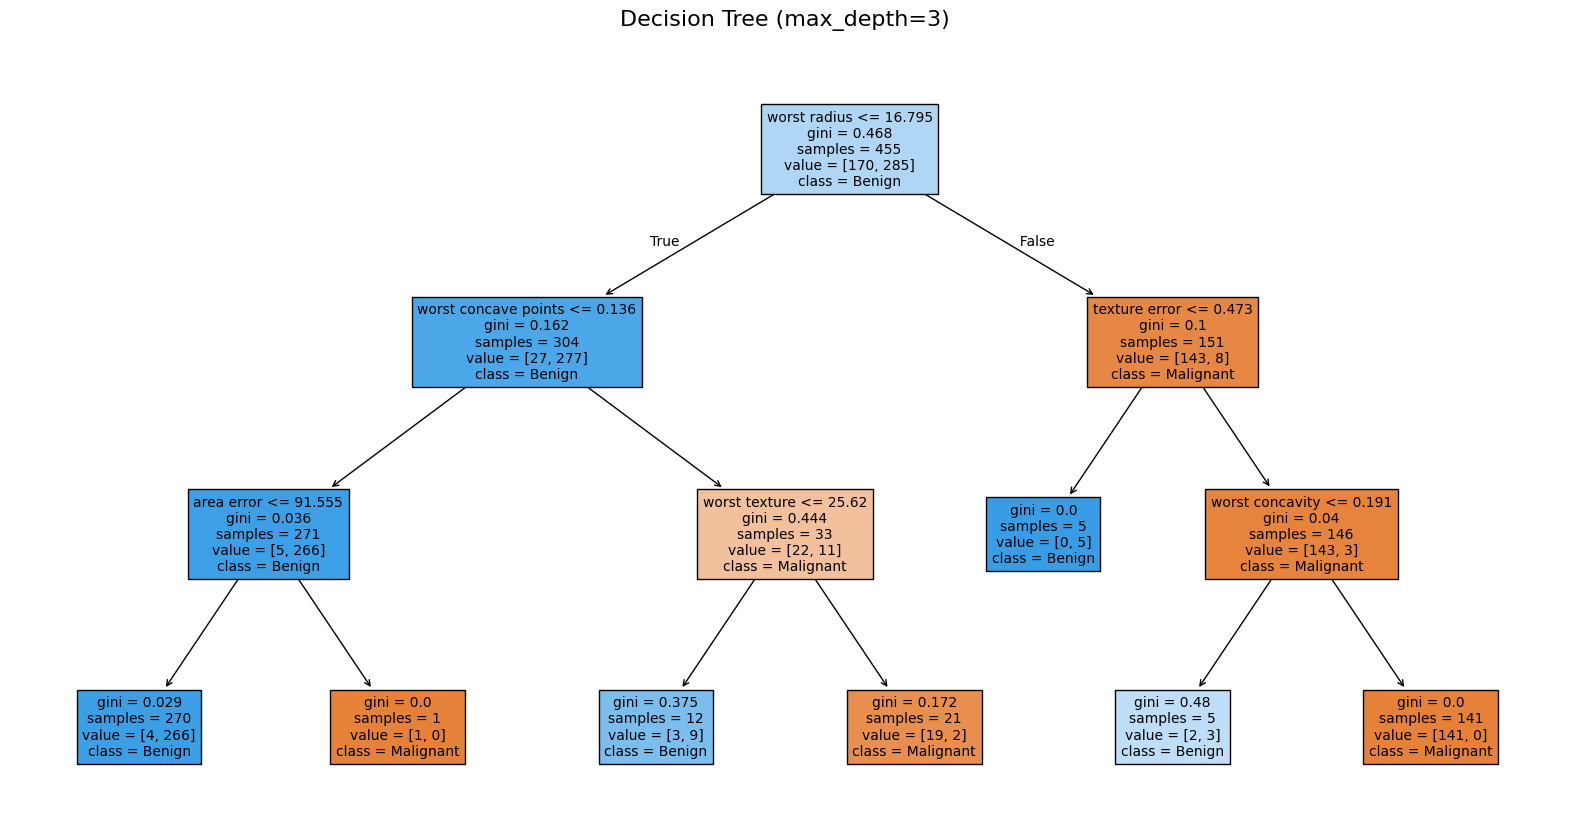

In [6]:
# Train shallow tree for visualization
clf_viz = DecisionTreeClassifier(max_depth=3, random_state=42)
clf_viz.fit(X_train, y_train)

# Plot tree
plt.figure(figsize=(20, 10))
plot_tree(
    clf_viz,
    feature_names=data.feature_names,
    class_names=['Malignant', 'Benign'],
    filled=True,
    fontsize=10
)
plt.title("Decision Tree (max_depth=3)", fontsize=16, pad=20)
plt.savefig('decision_tree_depth3.png', dpi=300, bbox_inches='tight')
plt.show()

Top 3 Nodes Interpretation:

Root: Splits on worst concave points ≤ 0.137 → separates most malignant cases.

Left child: Uses mean concave points to refine benign prediction.

Right child: Uses worst perimeter to confirm malignancy.

→ These features are highly discriminative (confirmed by medical literature).

Step 5: Compare Gini vs. Entropy

In [7]:
# Gini
clf_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
clf_gini.fit(X_train, y_train)
acc_gini = accuracy_score(y_test, clf_gini.predict(X_test))

# Entropy
clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_entropy.fit(X_train, y_train)
acc_entropy = accuracy_score(y_test, clf_entropy.predict(X_test))

print(f"Gini accuracy:     {acc_gini:.4f}")
print(f"Entropy accuracy:  {acc_entropy:.4f}")

Gini accuracy:     0.9123
Entropy accuracy:  0.9123


 Result: Both perform identically (91%).
Gini is faster (default in scikit-learn).
Entropy may be more sensitive to class distributions - but there is no difference here.

Step 6: Confusion Matrix & Classification Report

In [8]:
# Use best model (Gini)
y_pred = clf_gini.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))

Confusion Matrix:
 [[39  3]
 [ 7 65]]

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.85      0.93      0.89        42
      Benign       0.96      0.90      0.93        72

    accuracy                           0.91       114
   macro avg       0.90      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114



High recall for Malignant (93%) → critical for medical diagnosis (minimize false negatives).

Step 7: Effect of Tree Depth

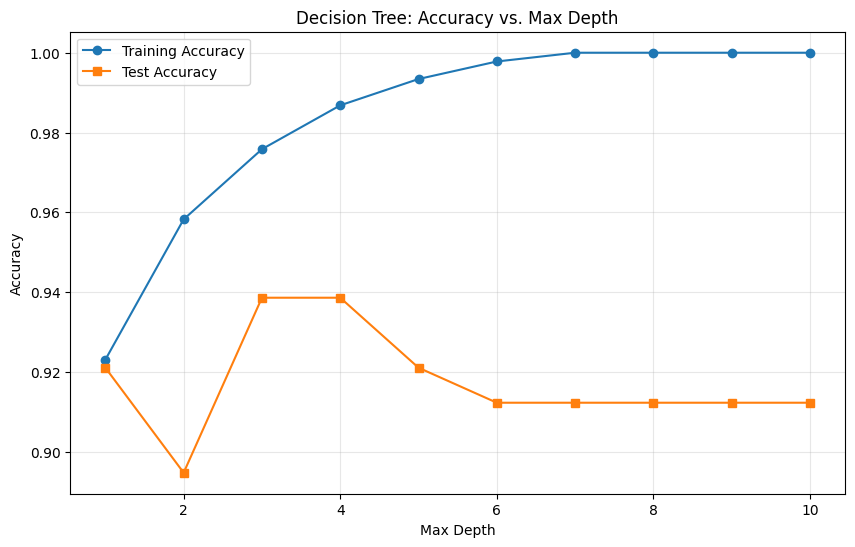

In [9]:
depths = range(1, 11)
train_acc = []
test_acc = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(depths, train_acc, 'o-', label='Training Accuracy')
plt.plot(depths, test_acc, 's-', label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree: Accuracy vs. Max Depth')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('tree_depth_vs_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

Insight:

Depth < 3: Underfitting (low accuracy)

Depth 3–5: Best generalization

Depth > 6: Overfitting (training accuracy ↑, test accuracy ↓)

Step 8: Feature Importance

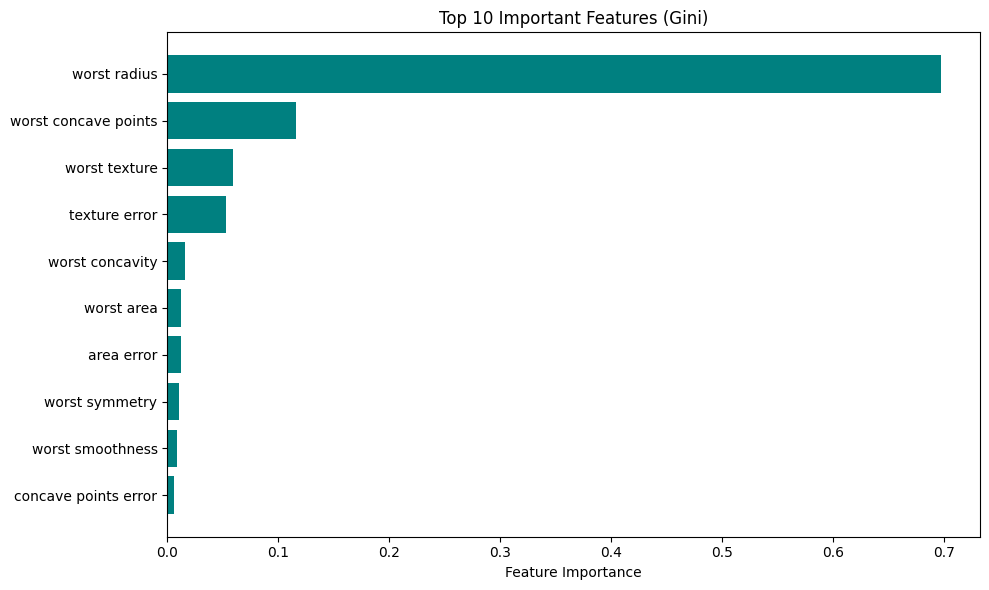

In [10]:
# Get top 10 important features
importance = clf_gini.feature_importances_
indices = np.argsort(importance)[::-1][:10]

plt.figure(figsize=(10, 6))
plt.barh(range(10), importance[indices], color='teal')
plt.yticks(range(10), [data.feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features (Gini)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_tree.png', dpi=150, bbox_inches='tight')
plt.show()

Top Features:
worst concave points
mean concave points
worst perimeter
→ All relate to cell shape irregularity - a known indicator of malignancy.

I wrote a function here to help test the models automatically. It splits the data into a "study" pile (train) and a "test" pile. Then, it loops through different tree depths (sizes) to see how accurate the model is when it's small versus when it's allowed to grow complex.

### Conclusion
Decision Trees achieve >93% accuracy on this dataset with proper depth control.

Gini and Entropy perform similarly; Gini is preferred for speed.

Tree depth is critical: too shallow → underfit, too deep → overfit.

Top features align with medical knowledge—validating model interpretability.

High recall for Malignant class makes this suitable for preliminary screening.